## 1. Import Dataset

In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [51]:
bank = pd.read_csv('bank-full.csv')

## 2. Data Preprocessing

In [52]:
bank.replace(('yes','no'),(1,0),inplace=True)
bank['education'].replace(('secondary','tertiary','primary','unknown'),(2,3,1,2),inplace=True)

In [53]:
cat_features = bank.select_dtypes(include=['object']).axes[1]

In [54]:
# 더미화
def merge_dummy_data(data, cat_features):
    for cat_feature in cat_features:
        tmp = pd.get_dummies(data[cat_feature], prefix=cat_feature, drop_first=True)
        
        data = pd.concat([data, tmp], 1)
    data = data.drop(cat_features, 1)       
    return data

In [55]:
dummied_data = merge_dummy_data(bank, cat_features)

In [56]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

def scalingcolumns(df, cols_to_scale):
    for col in cols_to_scale:
        df[col] = pd.DataFrame( sc.fit_transform(pd.DataFrame(df[col])),columns=[col] )
    return df

In [57]:
cols_to_scale = dummied_data.columns[0:11]
scaled_data = scalingcolumns(dummied_data,cols_to_scale)

In [58]:
X = scaled_data[list(set(scaled_data.columns)-set('y'))]
y = scaled_data['y']

In [59]:
X.shape, y.shape

((45211, 40), (45211,))

## 3. PCA
### 40개의 feature -> 9개로 축소 (81% 설명)

In [60]:
from sklearn.decomposition import PCA

from sklearn.cluster import KMeans,DBSCAN
from online_som import SOM

In [61]:
pca = PCA()
pca.fit(X)
pca_values = pca.transform(X)

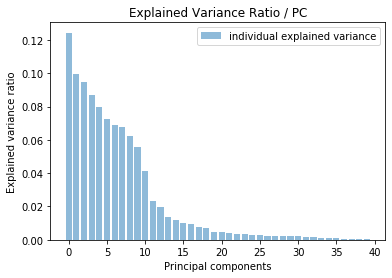

In [62]:
plt.bar(range(X.shape[1]),pca.explained_variance_ratio_, alpha=0.5, align='center', label='individual explained variance')

plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.title('Explained Variance Ratio / PC')
plt.legend(loc='best')
plt.show()

In [63]:
pca.explained_variance_ratio_.cumsum()[9].round(2)

0.81

Text(0.5, 1.0, 'cumulative Explained Variance Ratio')

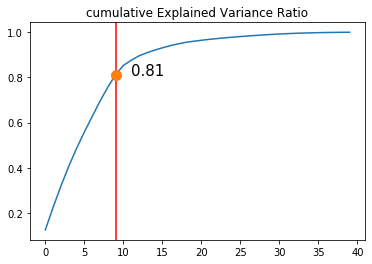

In [64]:
plt.plot(pca.explained_variance_ratio_.cumsum())
plt.axvline(9,color='red')
plt.plot(9,0.81,'o',markersize=10)
plt.text(11,0.81,'0.81',size=15)
plt.title('cumulative Explained Variance Ratio')

### 9개로 결정!

In [65]:
pca2 = PCA(n_components=9)
pca2.fit(X)
pca_values2 = pca2.transform(X)

In [66]:
pcadf = pd.DataFrame(pca_values2, columns = ['PC'+str(i) for i in range(1,10)])
pcadf.index = X.index
pcadf.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9
0,0.013812,0.618380,-0.068002,-1.286128,0.027843,-0.717797,-0.210574,0.630734,0.440886
1,0.139942,-0.676180,-0.663513,-1.149365,-0.357059,-1.120232,0.212300,0.026766,0.227914
2,0.066223,-1.770194,-1.075490,-0.507576,0.819475,-0.941087,-1.866943,0.512138,0.404807
3,0.051579,-0.157233,-1.137653,-0.993901,-0.568030,-1.198241,0.059781,0.535710,0.223786
4,-0.177710,-0.209624,0.114222,-1.221594,0.386854,-1.166393,0.406819,-0.747864,0.214879


In [67]:
# 차원이 축소된 것을 확인할 수 있다
X.shape, pcadf.shape

((45211, 40), (45211, 9))

### outlier 제거

In [69]:
pcadf.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9
0,0.013812,0.618380,-0.068002,-1.286128,0.027843,-0.717797,-0.210574,0.630734,0.440886
1,0.139942,-0.676180,-0.663513,-1.149365,-0.357059,-1.120232,0.212300,0.026766,0.227914
2,0.066223,-1.770194,-1.075490,-0.507576,0.819475,-0.941087,-1.866943,0.512138,0.404807
3,0.051579,-0.157233,-1.137653,-0.993901,-0.568030,-1.198241,0.059781,0.535710,0.223786
4,-0.177710,-0.209624,0.114222,-1.221594,0.386854,-1.166393,0.406819,-0.747864,0.214879


In [70]:
pcadf['y'] = y

In [29]:
from scipy import stats

for i in pcadf.columns[:-1]:
    pcadf = pcadf[np.abs(pcadf[i]-pcadf[i].mean()) <= (3*pcadf[i].std())]

In [30]:
pcadf.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,y
0,0.013812,0.618380,-0.068001,-1.286128,0.027843,-0.717797,-0.210572,0.630735,0.440884,0
1,0.139942,-0.676180,-0.663513,-1.149365,-0.357059,-1.120233,0.212301,0.026766,0.227912,0
2,0.066223,-1.770193,-1.075489,-0.507574,0.819476,-0.941089,-1.866938,0.512141,0.404799,0
3,0.051579,-0.157233,-1.137654,-0.993902,-0.568032,-1.198239,0.059776,0.535709,0.223793,0
4,-0.177710,-0.209624,0.114222,-1.221593,0.386854,-1.166394,0.406822,-0.747862,0.214874,0


In [31]:
# 차원이 축소된 것을 확인할 수 있다
X.shape, pcadf.shape

((45211, 40), (41396, 10))

In [32]:
pcadf.to_csv('pca_XY.csv')

In [33]:
pcadf = pcadf.iloc[:,:-1]

# 4. Clustering

### 1) K-Means

In [86]:
sse = [] 

for i in range(3,12) :
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(pcadf)
    sse.append(kmeans.inertia_)

In [87]:
sse

[211470.32475764118,
 181011.1132235823,
 161788.99693394234,
 151227.047622287,
 142845.1882798553,
 137469.9564944125,
 130774.82767437291,
 125645.06607283805,
 121174.33202844282]

Text(0.5, 1.0, 'K-Means SSE')

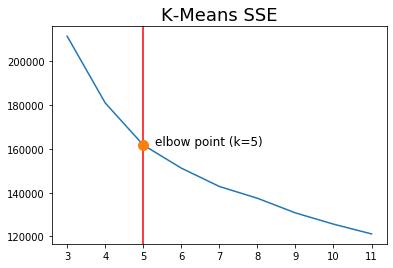

In [95]:
plt.plot(range(3,12),sse)
plt.axvline(5,color='red')
plt.plot(5,161788,'o',markersize=10)
plt.text(5.3,161788,'elbow point (k=5)',size=12)
plt.title('K-Means SSE',size=18)

In [96]:
k5 = KMeans(n_clusters=5)
k5.fit(pcadf)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [97]:
pcadf_kmeans = pcadf.copy()
pcadf_kmeans['cluster'] = k5.labels_

In [98]:
pcadf_kmeans['cluster'].value_counts()

1    11643
3    10864
0     7648
4     5956
2     5285
Name: cluster, dtype: int64

Text(0.5, 1.0, 'K-Means')

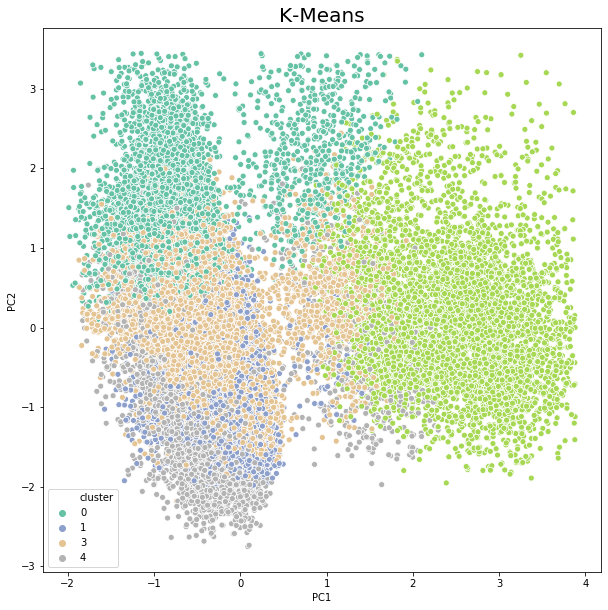

In [166]:
plt.figure(figsize=(10,10))
sns.scatterplot(x="PC1", y="PC2", hue="cluster",palette="Set2",data=pcadf_kmeans)
plt.title('K-Means', fontsize=20)

### 2) DBSCAN

In [128]:
#db = DBSCAN(eps=0.3, min_samples=10).fit(pcadf)
db = DBSCAN(eps=1.5).fit(pcadf)

In [129]:
pcadf_dbscan = pcadf.copy()
pcadf_dbscan['cluster'] = db.labels_

In [130]:
pcadf_dbscan.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,cluster
0,0.013812,0.618380,-0.068002,-1.286128,0.027843,-0.717798,-0.210573,0.630735,0.440883,0
1,0.139942,-0.676180,-0.663513,-1.149365,-0.357059,-1.120233,0.212301,0.026766,0.227911,0
2,0.066223,-1.770193,-1.075489,-0.507574,0.819477,-0.941089,-1.866937,0.512142,0.404800,1
3,0.051579,-0.157233,-1.137654,-0.993902,-0.568032,-1.198240,0.059776,0.535708,0.223792,0
4,-0.177710,-0.209624,0.114222,-1.221593,0.386855,-1.166395,0.406823,-0.747862,0.214874,0


Text(0.5, 1.0, 'DBSCAN')

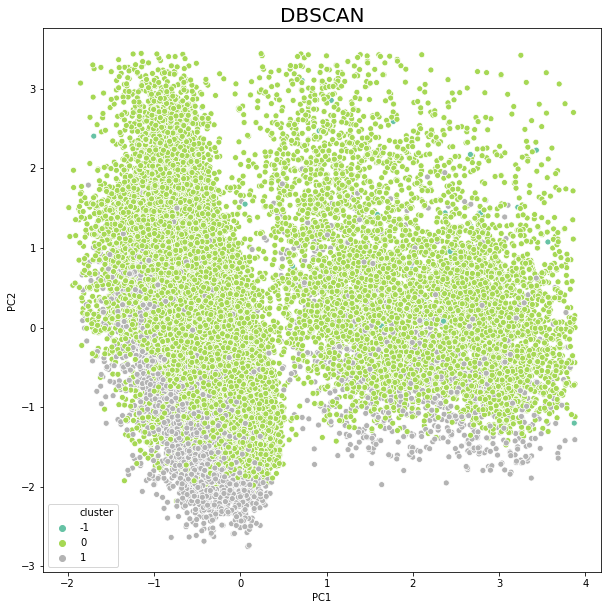

In [167]:
plt.figure(figsize=(10,10))
sns.scatterplot(x="PC1", y="PC2", hue="cluster",palette="Set2",data=pcadf_dbscan)
plt.title('DBSCAN', fontsize=20)

### 3) SOM 

In [140]:
agri_som = SOM(2,3,9)

agri_som.train(pcadf.values,
          num_epochs=200,
          init_learning_rate=0.01
          )

SOM training epoches 20
neighborhood radius  1.8660659830736148
learning rate  0.009048374180359595
-------------------------------------
SOM training epoches 40
neighborhood radius  1.7411011265922482
learning rate  0.008187307530779819
-------------------------------------
SOM training epoches 60
neighborhood radius  1.6245047927124712
learning rate  0.007408182206817179
-------------------------------------
SOM training epoches 80
neighborhood radius  1.5157165665103982
learning rate  0.006703200460356393
-------------------------------------
SOM training epoches 100
neighborhood radius  1.4142135623730951
learning rate  0.006065306597126334
-------------------------------------
SOM training epoches 120
neighborhood radius  1.3195079107728944
learning rate  0.005488116360940265
-------------------------------------
SOM training epoches 140
neighborhood radius  1.2311444133449163
learning rate  0.004965853037914096
-------------------------------------
SOM training epoches 160
neighb

In [141]:
def predict2x3(df):
    bmu, bmu_idx = agri_som.find_bmu(df.values)
    df['bmu'] = bmu
    df['bmu_idx'] = bmu_idx
    return df

In [142]:
clustered_df = pcadf.apply(predict2x3, axis=1)
clustered_df['bmu_idx'] = clustered_df['bmu_idx'].astype('str')

In [143]:
clustered_df['bmu_idx'].value_counts()

[0 2]    8274
[1 2]    7962
[1 0]    7710
[0 0]    7551
[0 1]    5941
[1 1]    3958
Name: bmu_idx, dtype: int64

In [149]:
X_SOM = X.copy()
pca_SOM = pcadf.copy()

X_SOM['cluster'] = pd.Series(clustered_df['bmu_idx'])
pca_SOM['cluster'] = pd.Series(clustered_df['bmu_idx'])

In [150]:
X_SOM.cluster.value_counts()

[0 2]    8274
[1 2]    7962
[1 0]    7710
[0 0]    7551
[0 1]    5941
[1 1]    3958
Name: cluster, dtype: int64

In [152]:
pca_SOM.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,cluster
0,0.013812,0.618380,-0.068002,-1.286128,0.027843,-0.717798,-0.210573,0.630735,0.440883,[1 1]
1,0.139942,-0.676180,-0.663513,-1.149365,-0.357059,-1.120233,0.212301,0.026766,0.227911,[0 2]
2,0.066223,-1.770193,-1.075489,-0.507574,0.819477,-0.941089,-1.866937,0.512142,0.404800,[1 2]
3,0.051579,-0.157233,-1.137654,-0.993902,-0.568032,-1.198240,0.059776,0.535708,0.223792,[1 2]
4,-0.177710,-0.209624,0.114222,-1.221593,0.386855,-1.166395,0.406823,-0.747862,0.214874,[0 0]


Text(0.5, 1.0, 'SOM 2x3')

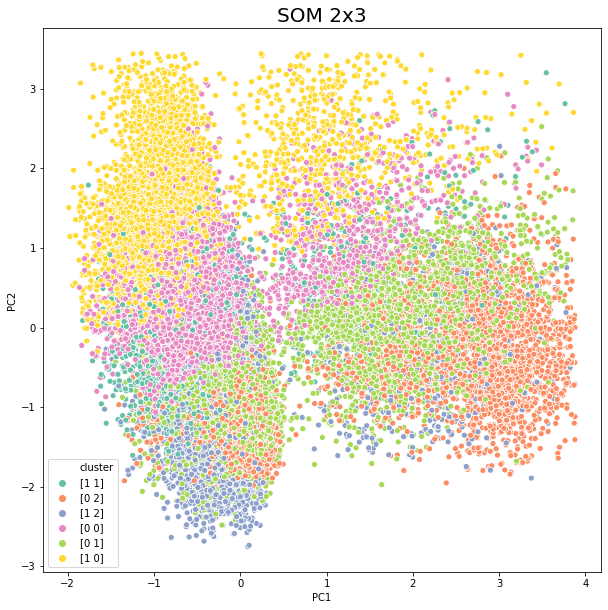

In [168]:
plt.figure(figsize=(10,10))
sns.scatterplot(x="PC1", y="PC2", hue="cluster",palette="Set2",data=pca_SOM)
plt.title('SOM 2x3', fontsize=20)

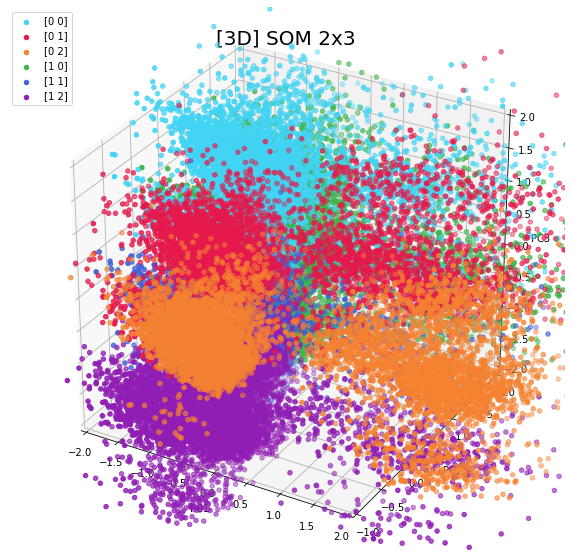

In [169]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')


ax.scatter(clustered_df[clustered_df['bmu_idx']=='[0 0]']['PC1'],
           clustered_df[clustered_df['bmu_idx']=='[0 0]']['PC2'],
           clustered_df[clustered_df['bmu_idx']=='[0 0]']['PC3'], c='#42d4f4', marker='o',label='[0 0]')

ax.scatter(clustered_df[clustered_df['bmu_idx']=='[0 1]']['PC1'],
           clustered_df[clustered_df['bmu_idx']=='[0 1]']['PC2'],
           clustered_df[clustered_df['bmu_idx']=='[0 1]']['PC3'], c='#e6194B', marker='o',label='[0 1]')

ax.scatter(clustered_df[clustered_df['bmu_idx']=='[0 2]']['PC1'],
           clustered_df[clustered_df['bmu_idx']=='[0 2]']['PC2'],
           clustered_df[clustered_df['bmu_idx']=='[0 2]']['PC3'], c='#f58231', marker='o', label='[0 2]')

ax.scatter(clustered_df[clustered_df['bmu_idx']=='[1 0]']['PC1'],
           clustered_df[clustered_df['bmu_idx']=='[1 0]']['PC2'],
           clustered_df[clustered_df['bmu_idx']=='[1 0]']['PC3'], c='#3cb44b', marker='o', label='[1 0]')

ax.scatter(clustered_df[clustered_df['bmu_idx']=='[1 1]']['PC1'],
           clustered_df[clustered_df['bmu_idx']=='[1 1]']['PC2'],
           clustered_df[clustered_df['bmu_idx']=='[1 1]']['PC3'], c='#4363d8', marker='o', label='[1 1]')

ax.scatter(clustered_df[clustered_df['bmu_idx']=='[1 2]']['PC1'],
           clustered_df[clustered_df['bmu_idx']=='[1 2]']['PC2'],
           clustered_df[clustered_df['bmu_idx']=='[1 2]']['PC3'], c='#911eb4', marker='o', label='[1 2]')
   

ax.set_xlabel('PC1')
ax.set_xlim(-2,2)
ax.set_ylabel('PC2')
ax.set_ylim(-1,2)
ax.set_zlabel('PC3')
ax.set_zlim(-2,2)
plt.title('[3D] SOM 2x3', fontsize=20)
plt.legend()
plt.show()

In [162]:
X_SOM.to_csv('X_SOM.csv')

In [163]:
pca_SOM.to_csv('pca_SOM.csv')